<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/focus_MM/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libreries and Dataset preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
from tqdm.keras import TqdmCallback
import gc
import time 
# import numba
import os
import scipy.fftpack
import cv2
import random
from scipy.special import gamma


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras

import tensorflow_hub as hub

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100
sr = 16000
# sr = 22050

In [2]:
! pip install icecream --quiet
from icecream import ic

In [3]:
! pip install samplerate --quiet
import samplerate

     |████████████████████████████████| 4.0MB 10.6MB/s 


In [4]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 307kB 8.1MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 174kB 16.1MB/s 
     |████████████████████████████████| 112kB 15.1MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 143kB 16.3MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 


In [5]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [6]:
! pip install audiomentations --quiet
import audiomentations as am

     |████████████████████████████████| 184kB 12.3MB/s 


Get Dataset

In [7]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [8]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


# Part 1: Baseline ConvNet

## Preprocessing and input pipeline functions

In [ ]:
class AudioLoader():
    def __init__(self, df, root, format1=False, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out

def get_mel(y):
    mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(y.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=128))
    mel = (mel - np.min(mel))/(np.max(mel) - np.min(mel))
    return mel

def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed


def base_features_preprocessor(audio_loader, path, df, augmentation=0):

    augment = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    am.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    am.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),])


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            this_mel = get_mel(this_audio)
            pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    this_mel = get_mel(this_audio)
                    pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    aug_audio = augment(this_audio, sr)
                    this_mel = get_mel(this_audio)
                    pack = np.array([this_mel, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


filename    1-11687-A-47.wav
fold                       1
target                    47
category            airplane
esc10                  False
src_file               11687
take                       A
Name: 25, dtype: object


ic| asd.shape: (128, 500)


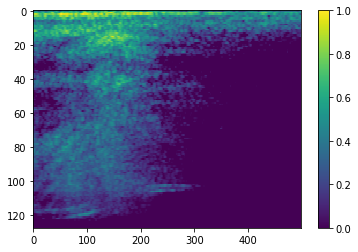

In [ ]:
audio_loader = AudioLoader(data_info, ROOT, format1=True, downsample=True)
asd = get_mel(audio_loader[25])
print(audio_loader.get_info(25))
ic(asd.shape)

plt.figure()
plt.imshow(asd, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
ic(ROOT)
AUGMENTATION = 0

!mkdir -p baseline_storage
path_base = "/content/baseline_storage/"

audio_loader = AudioLoader(data_info, ROOT, format1=True)
base_features_preprocessor(audio_loader, path_base, data_info, augmentation=AUGMENTATION)

ic| ROOT: '/content/ESC-50/audio/'


In [ ]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mix(a, b, l):
    return l*b + (1-l)*a


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, alpha_schedule=None, mixup='none', wait_mix=0):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.mixup = mixup
        self.epoch = 0
        self.alpha = [0.01, 0.01]
        self.mix_prob = 1
        self.wait_mix = wait_mix
        if self.mixup != 'none':
            self.alpha_schedule = alpha_schedule
        else:
            self.alpha_schedule = None

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.mixup != 'none' and self.epoch < self.alpha_schedule.shape[1]:
            self.alpha = self.alpha_schedule[:,self.epoch]

        # print('deb alpha', self.alpha[0], self.alpha[1])
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            this_feat = this_pack[0]
            this_target = to_onehot(this_pack[2])
            
            if self.mixup != 'none' and self.epoch >= self.wait_mix:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.roll(this_feat2, np.random.randint(0,10), axis=0)
                this_target2 = to_onehot(this_pack2[2])

                if self.mixup == 'lossy':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)

                elif self.mixup == 'standard':
                    # mix the samples and the target
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)
                    this_target = mix(this_target, this_target2, l)  

                elif self.mixup == 'noise':
                    #use gaussian noise instead of the sample
                    feat2_std = np.std(this_feat2)
                    feat2_mean = np.mean(this_feat2)
                    noise_feat2 = np.random.normal(feat2_mean, feat2_std, this_feat2.shape)
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, noise_feat2, l)


            batch_feat.append(this_feat)
            batch_target.append(this_target)

        batch_input = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        batch_target = np.array(batch_target)
        # batch_input = batch_infered

        return batch_input, batch_target


## baseline model definition

In [ ]:
def make_baseConvNet(lr):

    drop = 0.2
    input_shape = (500, 128,1)
    input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), strides=(1,1), padding='same')(input)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(drop)(x)
    x = layers.MaxPool2D((2,2))(x)


    x = layers.GlobalAveragePooling2D()(x)
    x = tf.expand_dims(x, axis=1)

    x = layers.Conv1D(50, 1)(x)
    x = layers.Dropout(drop)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(50, 1)(x)
    x = layers.Softmax()(x)

    x = layers.GlobalAveragePooling1D()(x)

    model = keras.Model(inputs=input, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

baseline_model = make_baseConvNet(0.001)
baseline_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 128, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 500, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 128, 32)      9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 64, 32)       0     

## test with no mixup

In [ ]:
SOURCE = path_base
MIXUP = 'none'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 300

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.0005)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.5963541865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6276041865348816

--- Training on fold 3 ---



Best validation accuracy: 0.6614583134651184

--- Training on fold 4 ---



Best validation accuracy: 0.6848958134651184

--- Training on fold 5 ---



Best validation accuracy: 0.5729166865348816



Visualization of the k-fold training

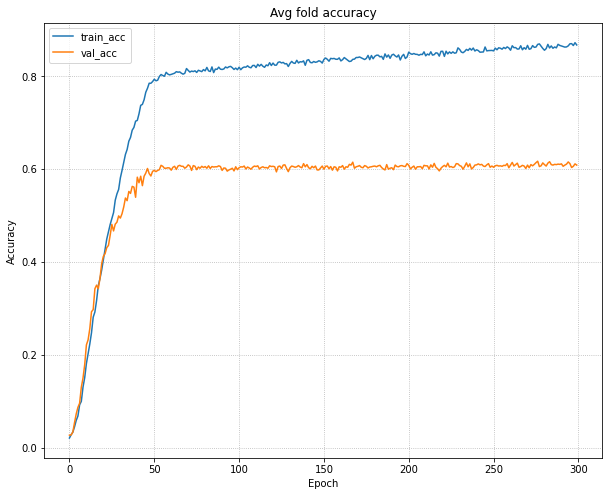

In [ ]:
fold_history_bnone = np.load(os.path.join(SAVE_PATH, 'baseline_'+MIXUP+'.npy'), allow_pickle=True)
loss = np.zeros((len(fold_history_bnone[0]['loss']),))
accuracy = np.zeros((len(fold_history_bnone[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_bnone[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_bnone[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()


## Test standard mixup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in power



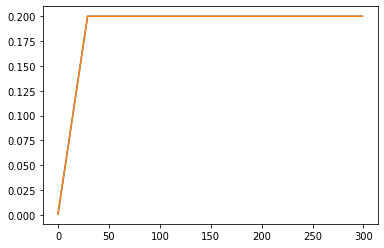

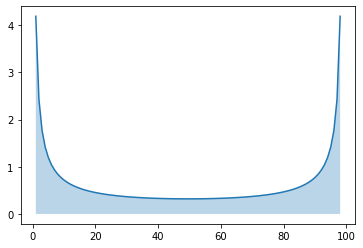

In [ ]:
epoch = 300
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.2
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end

plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_base
MIXUP = 'standard'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 300

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.0005)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6979166865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6796875

--- Training on fold 3 ---



Best validation accuracy: 0.65625

--- Training on fold 4 ---



Best validation accuracy: 0.7239583134651184

--- Training on fold 5 ---



Best validation accuracy: 0.671875



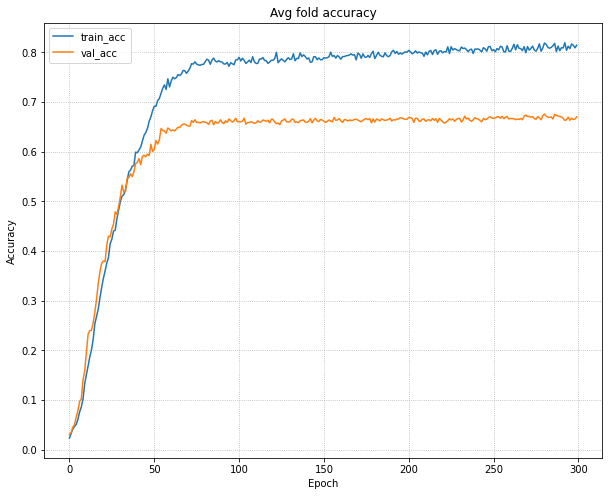

In [ ]:
fold_history_bstandard = np.load(os.path.join(SAVE_PATH, 'baseline_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_bstandard[0]['loss']),))
accuracy = np.zeros((len(fold_history_bstandard[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_bstandard[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_bstandard[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

## Test lossy mixup



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in power



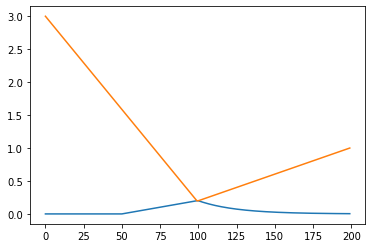

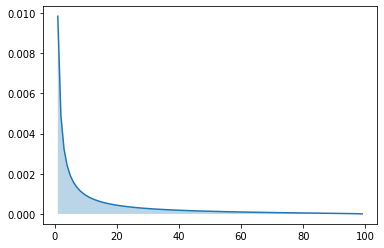

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-4
alpha_end = 0.2
alpha_schedule[:,0:50] = alpha_start
alpha_schedule[0,50:100] = np.linspace(alpha_start, alpha_end, 50)
alpha_schedule[0,100:] = alpha_end*np.exp(-np.linspace(0,4, 100))
alpha_schedule[1,100:] = np.linspace(alpha_end, 1, 100)
alpha_schedule[1,0:100] = np.linspace(3,alpha_end, 100)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )
plt.show()

In [ ]:
SOURCE = path_base
MIXUP = 'lossy'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 200

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP, wait_mix=50)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.001)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6432291865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6067708134651184

--- Training on fold 3 ---



Best validation accuracy: 0.5989583134651184

--- Training on fold 4 ---



Best validation accuracy: 0.7057291865348816

--- Training on fold 5 ---



Best validation accuracy: 0.5833333134651184



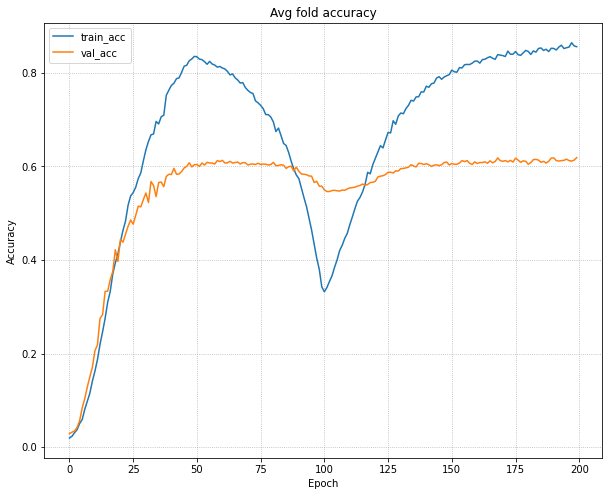

In [ ]:
fold_history_blossy = np.load(os.path.join(SAVE_PATH, 'baseline_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_blossy[0]['loss']),))
accuracy = np.zeros((len(fold_history_blossy[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_blossy[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_blossy[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

## Test noise mixup

In [ ]:
SOURCE = path_base
MIXUP = 'noise'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/baseline_record/'

batch_size = 64
epochs = 200

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]   

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP, wait_mix=50)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                                patience=5, min_lr=0.00001)

    baseline_model = make_baseConvNet(0.001)
    # Model training
    history = baseline_model.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                #    PlotLossesKeras(),
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                #    model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'baseline_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()
     



--- Training on fold 1 ---



Best validation accuracy: 0.6197916865348816

--- Training on fold 2 ---



Best validation accuracy: 0.6171875

--- Training on fold 3 ---



Best validation accuracy: 0.6354166865348816

--- Training on fold 4 ---



Best validation accuracy: 0.6796875

--- Training on fold 5 ---



Best validation accuracy: 0.59375



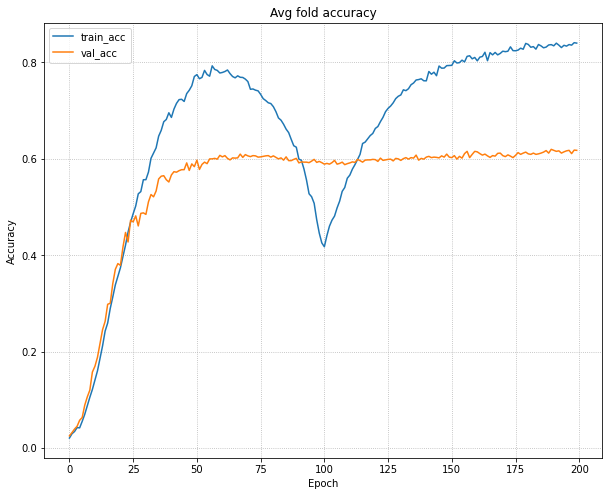

In [ ]:
fold_history_bnoise = np.load(os.path.join(SAVE_PATH, 'baseline_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_bnoise[0]['loss']),))
accuracy = np.zeros((len(fold_history_bnoise[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_bnoise[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_bnoise[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

# Part 2: YAMNet Transfer Learning

In [10]:
class AudioLoader():
    def __init__(self, df, root, format1=True, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed


def features_preprocessor(audio_loader, path, df, yamnet, augmentation=0):

    augment = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    am.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    am.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),])


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            _, this_emb, _ = yamnet(this_audio)
            pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    aug_audio = augment(this_audio, sr)
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

In [11]:
ic(ROOT)
AUGMENTATION = 0

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

# download ad set YAMNet pretrained model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_batch, data_info, yamnet_model, augmentation=AUGMENTATION)

ic| ROOT: '/content/ESC-50/audio/'


## Sequence class

In [12]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mix(a, b, l):
    return l*b + (1-l)*a


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, alpha_schedule=None, mixup='none'):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.mixup = mixup
        self.epoch = 0
        self.alpha = [0.01, 0.01]
        self.mix_prob = 1
        if self.mixup != 'none':
            self.alpha_schedule = alpha_schedule
        else:
            self.alpha_schedule = None

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.mixup != 'none' and self.epoch < self.alpha_schedule.shape[1]:
            self.alpha = self.alpha_schedule[:,self.epoch]

        # print('deb alpha', self.alpha[0], self.alpha[1])
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            this_feat = this_pack[0]
            this_target = to_onehot(this_pack[2])
            
            if self.mixup != 'none':
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.roll(this_feat2, np.random.randint(0,10), axis=0)
                this_target2 = to_onehot(this_pack2[2])

                if self.mixup == 'lossy':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)

                elif self.mixup == 'standard':
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, this_feat2, l)
                    this_target = mix(this_target, this_target2, l)  

                elif self.mixup == 'noise':
                    #use gaussian noise instead of the sample
                    feat2_std = np.std(this_feat2)
                    feat2_mean = np.mean(this_feat2)
                    noise_feat2 = np.random.normal(feat2_mean, feat2_std, this_feat2.shape)
                    # mix the samples
                    l = np.random.beta(self.alpha[0], self.alpha[1])
                    this_feat = mix(this_feat, noise_feat2, l)


            batch_feat.append(this_feat)
            batch_target.append(this_target)

        batch_infered = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        batch_target = np.array(batch_target)
        batch_input = batch_infered

        return batch_input, batch_target


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in power



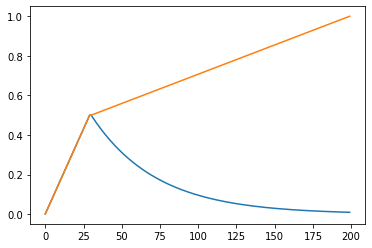

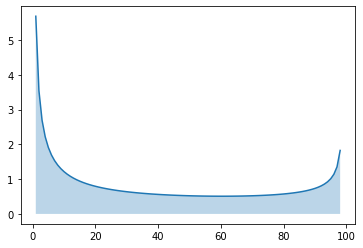

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

## Fine tuning model

In [14]:
def make_tfYAMNet(size_1=100, size_2=100, size_3=50, lr=1e-3):

    input_inf = layers.Input(shape=(None,1024))
    
    z = layers.GlobalAveragePooling1D()(input_inf)

    z = tf.expand_dims(z, axis=1)
    z = layers.Conv1D(size_1, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_2, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(size_3, 1, padding='same', activation='relu')(z)
    z = layers.Conv1D(50, 1, padding='same', activation='softmax')(z)
    z = layers.GlobalAveragePooling1D()(z)
    
    model = keras.Model(inputs=input_inf, outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

tfyam_net = make_tfYAMNet()
tfyam_net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 1024)              0         
_________________________________________________________________
tf.expand_dims_2 (TFOpLambda (None, 1, 1024)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 100)            102500    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 100)            10100     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 50)             5050      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 50)             2550

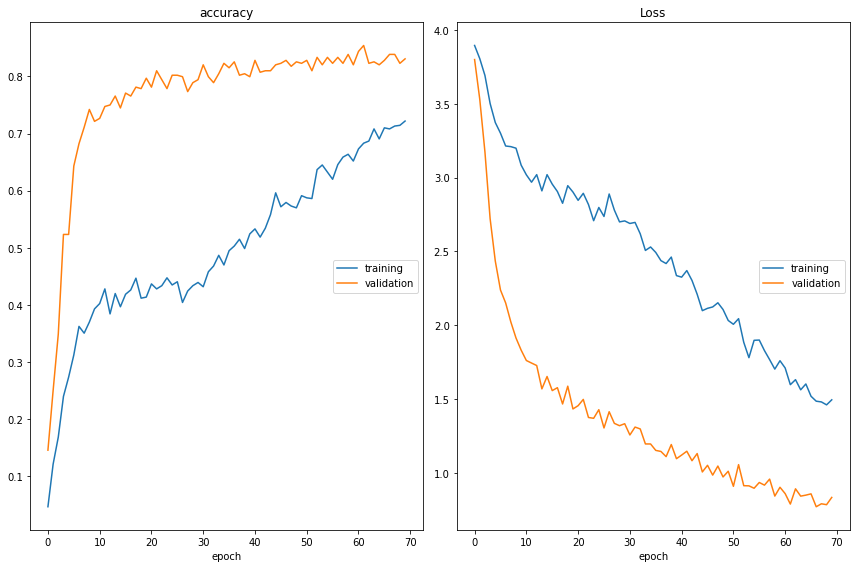

accuracy
	training         	 (min:    0.047, max:    0.722, cur:    0.722)
	validation       	 (min:    0.146, max:    0.854, cur:    0.831)
Loss
	training         	 (min:    1.460, max:    3.896, cur:    1.494)
	validation       	 (min:    0.769, max:    3.801, cur:    0.833)
Epoch 71/125
14/25 [===============>..............] - ETA: 1s - loss: 1.3744 - accuracy: 0.7455

In [ ]:
SOURCE = path_batch

batch_size = 64
epochs = 125

fold = 2
# feat_names  = os.listdir(path_drive)
feat_names  = os.listdir(SOURCE)
ic(len(feat_names))

# not using augmentated samples here
# val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]

train_names = [x for x in feat_names if x[0]!=str(fold) and x.endswith('0.npy')]
val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]

ic(len(train_names))
ic(len(val_names))

train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup='lossy')
val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')


ic(len(train_dataloader))
ic(len(val_dataloader))

model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_file,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)


tfyam_net = make_tfYAMNet(50, 50, 50, lr=0.001)
# Model training
history = tfyam_net.fit(train_dataloader, 
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr,
                               model_checkpoint_callback,
                               ],
                    validation_data = val_dataloader,
                    verbose=1)
# load the best model checkpoint
tfyam_net.load_weights(model_checkpoint_file)
best_acc = max(history.history['val_accuracy'])
print(best_acc)


# Optuna search

In [ ]:
SOURCE = path_batch
READ_AUG = False
fold = 2

def objective(trial):
   
    epochs = 125
    batch_size = trial.suggest_int('batch_size', 32,256)
    size_1 = trial.suggest_int('size_1', 50, 200)
    size_2 = trial.suggest_int('size_2', 50, 200)
    size_3 = trial.suggest_int('size_3', 50, 200)
    lr = lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)


    # feat_names  = os.listdir(path_drive)
    feat_names  = os.listdir(SOURCE)
    # ic(len(feat_names))

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]    

    # ic(len(train_names))
    # ic(len(val_names))

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup='lossy')
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, mixup='none')


    # ic(len(train_dataloader))
    # ic(len(val_dataloader))

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=5, min_lr=0.00005)


    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    # load the best model checkpoint
    tfyam_net.load_weights(model_checkpoint_file)
    best_acc = max(history.history['val_accuracy'])
    
    return best_acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=int(2.5*60*60))

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2021-06-16 13:44:13,571] A new study created in memory with name: no-name-66e92ae5-731e-480f-82fa-253ede2f5d26
[I 2021-06-16 13:49:44,336] Trial 0 finished with value: 0.893750011920929 and parameters: {'batch_size': 160, 'size_1': 198, 'size_2': 123, 'size_3': 199, 'lr': 0.00031874152012530664}. Best is trial 0 with value: 0.893750011920929.
[I 2021-06-16 13:56:17,126] Trial 1 finished with value: 0.8958333134651184 and parameters: {'batch_size': 84, 'size_1': 173, 'size_2': 198, 'size_3': 188, 'lr': 0.00029668375120813254}. Best is trial 1 with value: 0.8958333134651184.
[I 2021-06-16 14:01:47,433] Trial 2 finished with value: 0.8892045617103577 and parameters: {'batch_size': 88, 'size_1': 123, 'size_2': 94, 'size_3': 133, 'lr': 0.0007229764736567732}. Best is trial 1 with value: 0.8958333134651184.
[I 2021-06-16 14:06:51,291] Trial 3 finished with value: 0.02469135820865631 and parameters: {'batch_size': 162, 'size_1': 130, 'size_2': 172, 'size_3': 194, 'lr': 0.07001342456360396}

val Loss: 0.9194312691688538
Best hyperparameters: {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}


In [ ]:
best_params = {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Comparison with standard mixup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in power



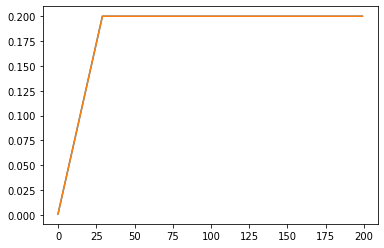

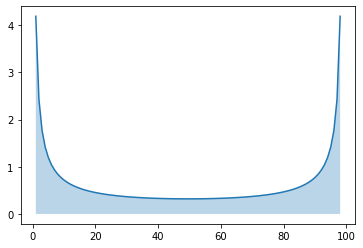

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.2
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end

plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_batch
MIXUP = 'standard'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00001)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()




--- Training on fold 1 ---



Best validation accuracy: 0.8815165758132935

--- Training on fold 2 ---



Best validation accuracy: 0.8862559199333191

--- Training on fold 3 ---



Best validation accuracy: 0.9052132964134216

--- Training on fold 4 ---



Best validation accuracy: 0.900473952293396

--- Training on fold 5 ---



Best validation accuracy: 0.9099525809288025



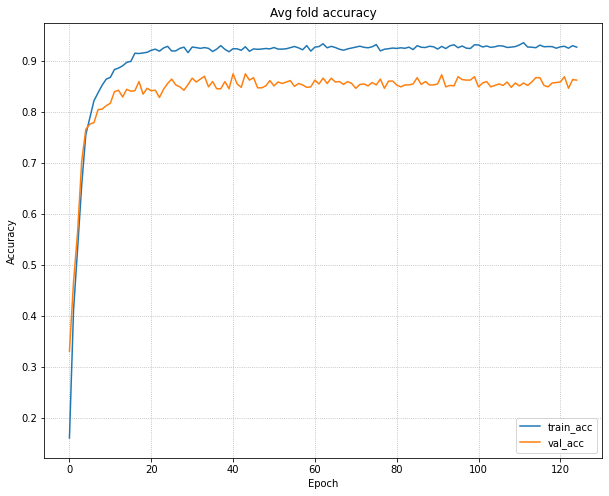

In [ ]:
fold_history_ystandard = np.load(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_ystandard[0]['loss']),))
accuracy = np.zeros((len(fold_history_ystandard[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_ystandard[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_ystandard[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

## Test lossy mixup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in power



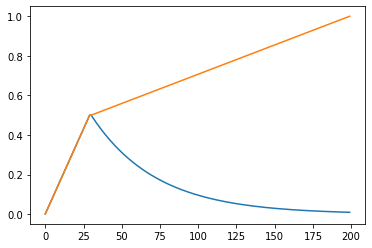

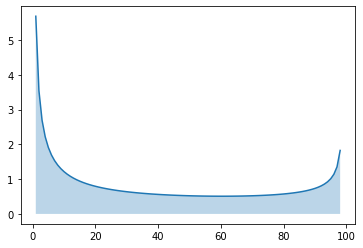

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_batch
MIXUP = 'lossy'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8625592589378357

--- Training on fold 2 ---



Best validation accuracy: 0.9146919250488281

--- Training on fold 3 ---



Best validation accuracy: 0.9099525809288025

--- Training on fold 4 ---



Best validation accuracy: 0.900473952293396

--- Training on fold 5 ---



Best validation accuracy: 0.9241706132888794



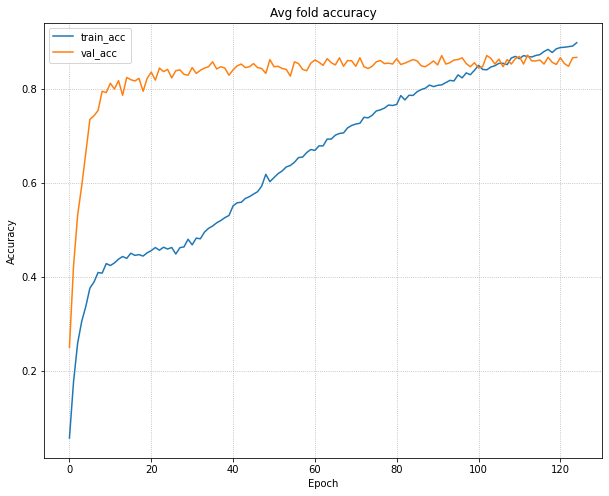

In [ ]:
fold_history_ylossy = np.load(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_ylossy[0]['loss']),))
accuracy = np.zeros((len(fold_history_ylossy[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_ylossy[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_ylossy[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

## Comparison with noisy mix up

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

divide by zero encountered in power



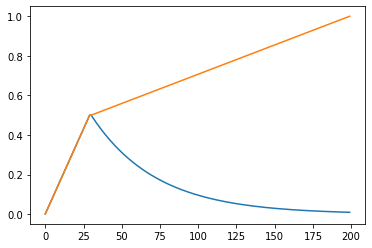

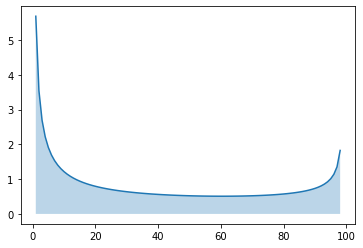

In [ ]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

In [ ]:
SOURCE = path_batch
MIXUP = 'noise'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8341231942176819

--- Training on fold 2 ---



Best validation accuracy: 0.8862559199333191

--- Training on fold 3 ---



Best validation accuracy: 0.8957346081733704

--- Training on fold 4 ---



Best validation accuracy: 0.9146919250488281

--- Training on fold 5 ---



Best validation accuracy: 0.9052132964134216



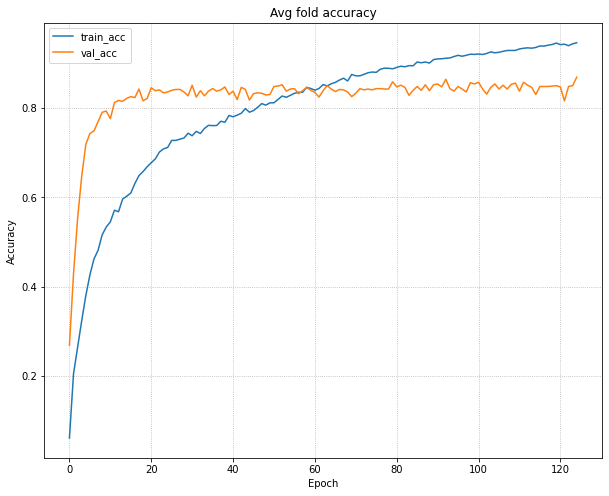

In [ ]:
fold_history_ynoise = np.load(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_ynoise[0]['loss']),))
accuracy = np.zeros((len(fold_history_ynoise[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_ynoise[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_ynoise[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

## test with no mixup

In [ ]:
SOURCE = path_batch
MIXUP = 'none'
READ_AUG = False
SAVE_PATH = '/content/drive/MyDrive/UNI_ICT/HDA/record/tfyamnet_record/'

batch_size = best_params['batch_size']
size_1 = best_params['size_1']
size_2 = best_params['size_2']
size_3 = best_params['size_3']
lr = best_params['lr']

epochs = 125

feat_names  = os.listdir(SOURCE)
fold_history = []

for fold in range(1,6):
    print(f'--- Training on fold {fold} ---')

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]  

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, mixup=MIXUP)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, mixup='none')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                                patience=5, min_lr=0.00005)

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_'+MIXUP+'_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    tfyam_net = make_tfYAMNet(size_1, size_2, size_3, lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                TqdmCallback(verbose=0), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    
    fold_history.append(history.history)
    np.save(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP), fold_history)

    best_acc = max(history.history['val_accuracy'])
    print(f'Best validation accuracy: {best_acc}')
    print()

--- Training on fold 1 ---



Best validation accuracy: 0.8578199148178101

--- Training on fold 2 ---



Best validation accuracy: 0.8909952640533447

--- Training on fold 3 ---



Best validation accuracy: 0.8909952640533447

--- Training on fold 4 ---



Best validation accuracy: 0.9099525809288025

--- Training on fold 5 ---



Best validation accuracy: 0.9099525809288025



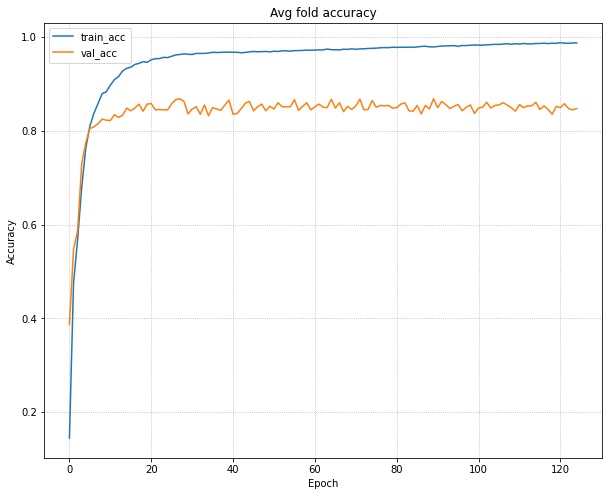

In [ ]:
fold_history_ynone = np.load(os.path.join(SAVE_PATH, 'tfyamnet_'+MIXUP+'.npy'), allow_pickle=True)

loss = np.zeros((len(fold_history_ynone[0]['loss']),))
accuracy = np.zeros((len(fold_history_ynone[0]['accuracy']),))
val_loss = np.zeros((len(fold_history_ynone[0]['val_loss']),))
val_accuracy = np.zeros((len(fold_history_ynone[0]['val_accuracy']),))
for d in fold_history:
    loss += np.array(list(d['loss']))
    accuracy += np.array(list(d['accuracy']))
    val_loss += np.array(list(d['val_loss']))
    val_accuracy += np.array(list(d['val_accuracy']))
loss /= 5
accuracy /= 5
val_loss /= 5
val_accuracy /= 5

# TODO variance shading
val_accuracy_std = np.std(val_accuracy)
accuracy_std = np.std(accuracy)
plt.figure(figsize=(10,8))
plt.plot(accuracy, label='train_acc')
plt.plot(val_accuracy, label='val_acc')
# plt.fill_between(np.arange(accuracy.shape[0]), accuracy+accuracy_std/2, accuracy-accuracy_std/2, alpha=0.2 )
# plt.fill_between(np.arange(val_accuracy.shape[0]), val_accuracy+val_accuracy_std/2, val_accuracy-val_accuracy_std/2, alpha=0.2 )
plt.legend()
plt.title('Avg fold accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(linestyle=':')
plt.show()

# Final Demonstration on an audio sequence

load best model 

In [21]:
model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
# best parameters from optuna search
best_params = {'batch_size': 211, 'size_1': 189, 'size_2': 158, 'size_3': 186, 'lr': 0.0007880421706148033}

In [19]:
best_model = make_tfYAMNet(best_params['size_1'], best_params['size_2'],best_params['size_3'], best_params['lr'] )
best_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d_10  (None, 1024)              0         
_________________________________________________________________
tf.expand_dims_5 (TFOpLambda (None, 1, 1024)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1, 189)            193725    
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 158)            30020     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1, 186)            29574     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 1, 50)             9350

In [57]:
# download ad set YAMNet pretrained model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
best_model.load_weights(os.path.join(model_checkpoint_dir, 'best_model_lossy_fold_5'))

## generate random audio sequence

In [29]:
import IPython as IP

problem loading a df that is not data_info???

In [49]:
# fold5_audio_loader = AudioLoader(data_info[data_info['fold']==5], ROOT, format1=True)
a = data_info[data_info['fold']==5]
fold5_audio_loader = AudioLoader(data_info, ROOT, format1=True)
fold5_audio_loader.get_info(-1)

filename    5-9032-A-0.wav
fold                     5
target                   0
category               dog
esc10                 True
src_file              9032
take                     A
Name: 1999, dtype: object

In [45]:
a = data_info[data_info['fold']==5]
a

,filename,fold,target,category,esc10,src_file,take
1600,5-103415-A-2.wav,5,2,pig,False,103415,A
1601,5-103416-A-2.wav,5,2,pig,False,103416,A
1602,5-103418-A-2.wav,5,2,pig,False,103418,A
1603,5-103420-A-2.wav,5,2,pig,False,103420,A
1604,5-103421-A-2.wav,5,2,pig,False,103421,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


2000


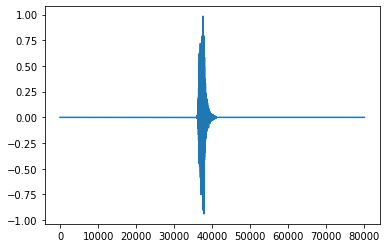

In [50]:
print(len(fold5_audio_loader))
plt.plot(fold5_audio_loader[0])

[1975  126 1878  602  966]


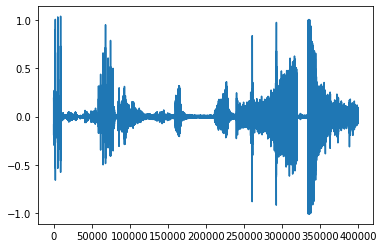

In [55]:
n = 5
SR = 16000
sequence_choice = np.random.randint(0,len(fold5_audio_loader), (n,))
print(sequence_choice)
asd = fold5_audio_loader[100]
sequence_audio = np.zeros((n*5*SR,))
for i in range(n):
    sequence_audio[i*5*SR:(i+1)*5*SR-1] = fold5_audio_loader[sequence_choice[i]] 

plt.plot(sequence_audio)

In [56]:
IP.display.Audio(sequence_audio, rate=SR)

classification

(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)
(1, 2, 1024)


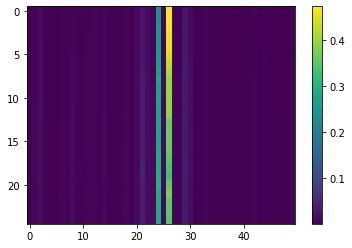

In [61]:
classification = np.zeros((int(sequence_audio.shape[0]/SR), 50))
for i in range(classification.shape[0]):
    _, emb, _ = yamnet_model(sequence_audio[i:i+1*SR])
    emb = np.expand_dims(emb, axis=0)
    print(emb.shape)
    classification[i,:] = best_model(emb)

plt.figure()
plt.imshow(classification, interpolation='nearest', aspect='auto')
plt.colorbar()